- 2020.07.31 kouui

- 2020.08.07 kouui Grotrian-plot, data-format, wavelength-in-air

---

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
import sys
sys.path.append("../../")

%load_ext autoreload
%autoreload 2

from src.Structure import AtomCls
from src.Atomic import Collision, SEsolver

from src.Util import Class

from src.Visual import Grotrian

import src.Constants as Cst
from src.Atomic import LTELib

import Lib2

---

In [3]:
folder = "../../data/atom/Ca_II/"
file_Level     = folder + "Ca_II.Level"
file_Aji = folder + "Einstein_A/Nist.Aji"
file_CEe = folder + "Collisional_Excitation/RH.Electron"
atom = AtomCls.Atom(file_Level, _file_Aji=file_Aji, _file_CEe=file_CEe)

file_CIe = folder + "Collisional_Ionization/RH.Electron"
atom.read_CI(_path_electron=file_CIe)

file_PI  = folder + "Photoionization/RH.Alpha"
atom.read_PI(_path_alpha=file_PI)

file_Rad = folder + "Ca_II.RadiativeLine"
atom.read_RadiativeLine_and_make_Line_Mesh(_path=file_Rad)
atom.make_Cont_Mesh()
atom.read_RadLine_intensity(_folder="../../data/intensity/Ca_II/")

Reading Einstein Aji coefficient from : 
 ../../data/atom/Ca_II/Einstein_A/Nist.Aji
...
Finished.

Reading Electron impact Effective Collisional Strength from : 
 ../../data/atom/Ca_II/Collisional_Excitation/RH.Electron
Finished.

Reading Electron impact Collisional Ionization coefficient from : 
 ../../data/atom/Ca_II/Collisional_Ionization/RH.Electron
Finished.

Reading Photoionization cross section from : 
 ../../data/atom/Ca_II/Photoionization/RH.Alpha
Finished.

Reading Radiative Line information from : 
 ../../data/atom/Ca_II/Ca_II.RadiativeLine
line mesh prepared.
continuum mesh prepared.


# SE (point)

In [6]:
Te = 1E4
Ne = 1E11
Tr = 6E3

# n_LTE : LTE population (summed up to 1)
# nj_by_ni_Line : nj/ni for line transitions
# nj_by_ni_Cont : nj/ni for Continuum transitions
n_LTE , nj_by_ni_Line, nj_by_ni_Cont = Lib2.ni_nj_LTE(atom, Te, Ne)

res = Lib2.bf_R_rate(atom, Te, nj_by_ni_Cont, _Tr=Tr)
Rik, Rki_stim, Rki_spon = res
Bij_Jbar, Bji_Jbar = Lib2.B_Jbar(atom, _Tr=Tr)
Cij = Lib2.get_Cij(atom, Te)
Cji = Collision.Cij_to_Cji( Cij, np.append(nj_by_ni_Line,nj_by_ni_Cont) )

In [7]:
#--- 
# set MatrixC (collisional)
#---
idxI = np.append(atom.Line.idxI[:], atom.Cont.idxI[:])
idxJ = np.append(atom.Line.idxJ[:], atom.Cont.idxJ[:])

nLevel = atom.nLevel
Cmat = np.zeros((nLevel, nLevel), dtype=np.double)
SEsolver.setMatrixC(_Cmat=Cmat[:,:], 
                    _Cji=Cji[:], 
                    _Cij=Cij[:],
                    _idxI=idxI, _idxJ=idxJ, _Ne=Ne)

#--- 
# set MatrixR (radiative)
#---
Rmat     = np.zeros((nLevel, nLevel), dtype=np.double)

Rji_spon = np.append(atom.Line.AJI[:], Rki_spon[:])
Rji_stim = np.append(Bij_Jbar[:], Rki_stim[:])
Rij = np.append(Bij_Jbar[:], Rik[:])

SEsolver.setMatrixR(_Rmat=Rmat[:,:], 
                    _Rji_spon=Rji_spon[:],
                    _Rji_stim=Rji_stim[:], 
                    _Rij=Rij[:], 
                    _idxI=idxI, _idxJ=idxJ)
#--- 
# solve statistical equilibrium equations
#---
n_SE = SEsolver.solveSE(_Rmat=Rmat[:,:], _Cmat=Cmat[:,:])

In [10]:
print(f"Electron temperature  = {Te:.1E}")
print(f"Electron density      = {Ne:.1E}")
print(f"Radiation temperature = {Tr:.1E}")
print("SE  :")
for v in n_SE:
    print(f"{v:.4E}",end="  ")
print(f"\nLTE :")
for v in n_LTE:
    print(f"{v:.4E}",end="  ")

Electron temperature  = 1.0E+04
Electron density      = 1.0E+11
Radiation temperature = 6.0E+03
SE  :
3.6527E-01  2.7457E-02  4.0766E-02  8.7318E-04  1.6506E-03  5.6398E-01  
LTE :
3.9829E-05  1.1176E-05  1.6618E-05  1.0619E-06  2.0568E-06  9.9993E-01  

# Detail Balance of radiative transitions

assuming

$$
T_{electron}=T_{radiation}
$$

then calculate the net rate in each line/continuum radiative transition

In [17]:
Te = 1E4
Ne = 1E12
Tr = Te

#n_LTE0, ni_LTE0, nj_LTE0 = Lib2.ni_nj_LTE_v0(atom,_Te,_Ne)
#_nj_by_ni_Line = nj_LTE0[:atom.nLine] / ni_LTE0[:atom.nLine]
#_nj_by_ni_Cont = nj_LTE0[atom.nLine:] / ni_LTE0[atom.nLine:]

n_LTE , nj_by_ni_Line, nj_by_ni_Cont = Lib2.ni_nj_LTE(atom, Te, Ne)

res = Lib2.bf_R_rate(atom, Te, nj_by_ni_Cont, _Tr=Tr)
Rik, Rki_stim, Rki_spon = res
Bij_Jbar, Bji_Jbar = Lib2.B_Jbar(atom, _Tr=Tr)

print("Line Transitions", end="\n")
for _lineIdx in range(atom.nLine):
    _nj_by_ni = nj_by_ni_Line[_lineIdx]
    print(f"wavelength : {atom.Line.w0_AA[_lineIdx]:.5E}[A]", end="    ")
    print("net rate = ", end="")
    netrate = (atom.Line.AJI[_lineIdx] + Bji_Jbar[_lineIdx]) * _nj_by_ni \
               - Bij_Jbar[_lineIdx]
    print(f"{netrate:+.4E}")

print()
print("Continuum Transitions", end="\n")
for _contIdx in range(atom.nCont):
    _nj_by_ni = nj_by_ni_Cont[_contIdx]
    print(f"wavelength : {atom.Cont.w0_AA[_contIdx]:.5E}[A]", end="    ")
    print("net rate = ", end="")
    netrate = (Rki_spon[_contIdx]+Rki_stim[_contIdx]) * _nj_by_ni - \
               Rik[_contIdx] 
    print(f"{netrate:+.4E}")


Line Transitions
wavelength : 7.32590E+03[A]    net rate = +0.0000E+00
wavelength : 7.29348E+03[A]    net rate = +0.0000E+00
wavelength : 3.96959E+03[A]    net rate = -1.3970E-09
wavelength : 3.93478E+03[A]    net rate = +0.0000E+00
wavelength : 1.64785E+06[A]    net rate = +0.0000E+00
wavelength : 8.66452E+03[A]    net rate = +2.3283E-10
wavelength : 8.50036E+03[A]    net rate = -5.8208E-11
wavelength : 8.71032E+03[A]    net rate = +0.0000E+00
wavelength : 8.54443E+03[A]    net rate = +0.0000E+00
wavelength : 4.48649E+05[A]    net rate = +0.0000E+00

Continuum Transitions
wavelength : 1.04437E+03[A]    net rate = +3.5527E-15
wavelength : 1.21800E+03[A]    net rate = +6.8212E-13
wavelength : 1.21890E+03[A]    net rate = +6.8212E-13
wavelength : 1.41723E+03[A]    net rate = +4.5475E-13
wavelength : 1.42172E+03[A]    net rate = +2.7285E-12


## Plots

### Transition rate plot in Grotrian diagram

#### show Grotrian

`Grotrian.Grotrian` to initialize a Grotrian object

`.make_fig` to setup a Grotrian level plot

`.show_fig` to show figure. 

every time once the figure has been showed, you need to `.make_fig` again to setup the plot

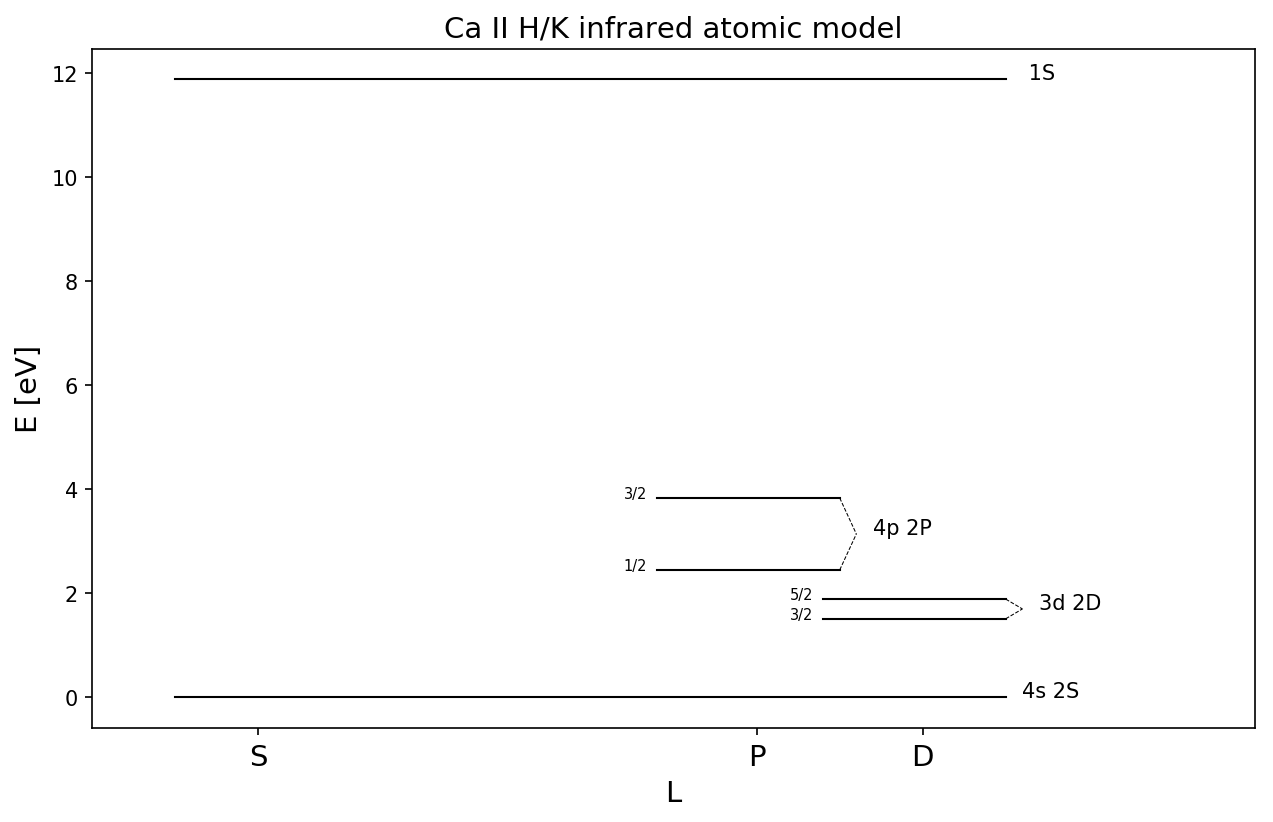

In [18]:
gro = Grotrian.Grotrian(_atom=atom, _path=folder + "/Ca_II.Grotrian")
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

gro.show_fig()

`plot_transitions` to connect transitions between levels

`_text_selection` keyword could be 

  - "all" : to plot all transitions in the configuration file

  -  "wavelength" : transitions in the configuration file with wavelength text (default)
  
  - list/tuple of wavelength text : to select the specific transitions

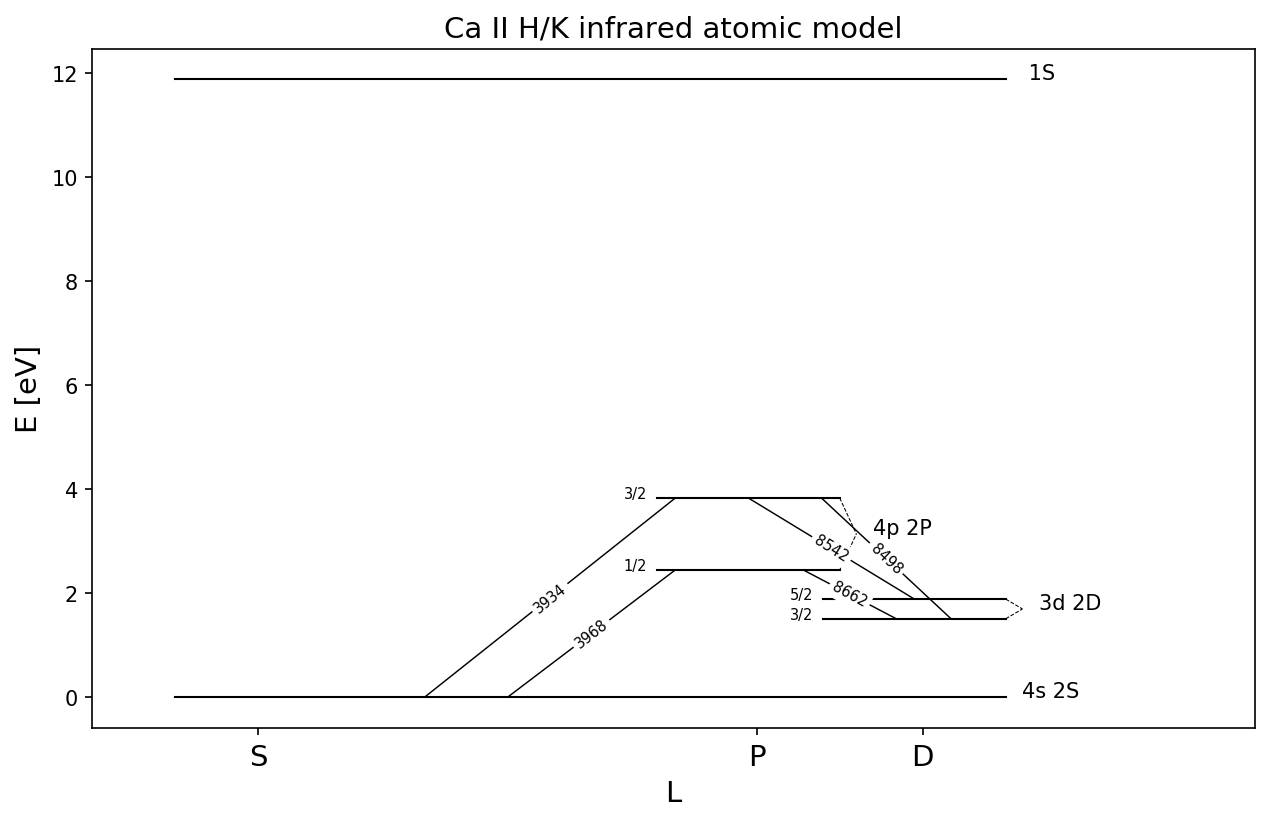

In [20]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

text_selection = ("3968", "3934") # "wavelength", "all"
gro.plot_transitions(_text_selection="wavelength")
gro.show_fig()

#### radiative transition rate

now we set

$$
T_{electron} \neq T_{radiation}
$$

to have net radiative transition rates

in `.plot_transition_rate` method,

  - `_abserr` defines an lower boundary that if 
  
      $$0 \le |rate| < abserror$$
      
    then the transition rate arrow will not be plotted. (default : 1E-5)

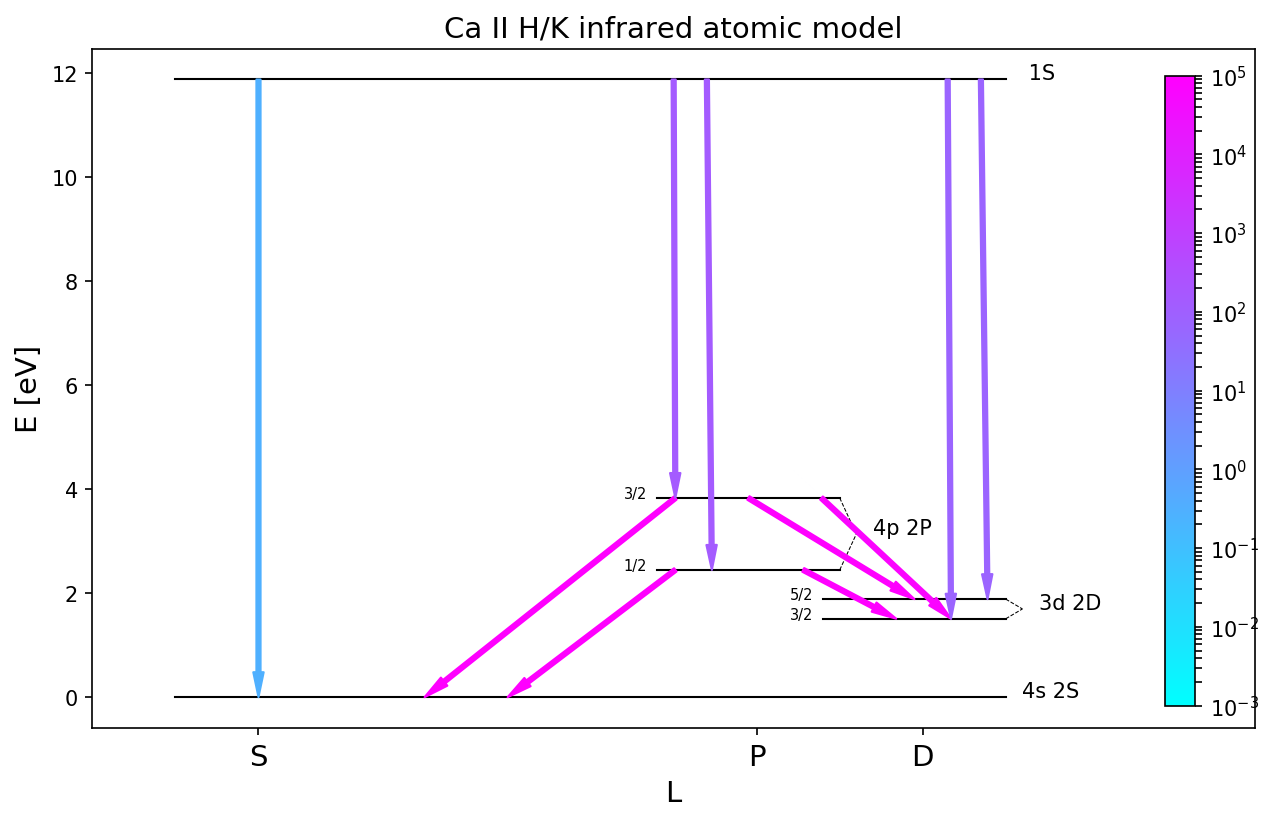

In [28]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

cmap = plt.get_cmap('cool')
norm = LogNorm(1E-3, 1E5, clip=True)


Te = 8E3
Ne = 1E12
Tr = 6E3

#n_LTE, ni_LTE, nj_LTE = Lib2.ni_nj_LTE_v0(atom,Te,Ne)
#nj_by_ni_Line = nj_LTE[:atom.nLine] / ni_LTE[:atom.nLine]
#nj_by_ni_Cont = nj_LTE[atom.nLine:] / ni_LTE[atom.nLine:]

n_LTE , nj_by_ni_Line, nj_by_ni_Cont = Lib2.ni_nj_LTE(atom, Te, Ne)

res = Lib2.bf_R_rate(atom, Te, nj_by_ni_Cont, _Tr=Tr)
Rik, Rki_stim, Rki_spon = res
Bij_Jbar, Bji_Jbar = Lib2.B_Jbar(atom, _Tr=Tr)

rate = np.append( Bji_Jbar*nj_by_ni_Line + 
                  atom.Line.AJI*nj_by_ni_Line - 
                  Bij_Jbar,
                  Rki_stim*nj_by_ni_Cont +
                  Rki_spon*nj_by_ni_Cont - 
                  Rik )

idxI = np.append( atom.Line.idxI, atom.Cont.idxI )
idxJ = np.append( atom.Line.idxJ, atom.Cont.idxJ )

gro.plot_transition_rate(_idxI=idxI, 
                         _idxJ=idxJ, 
                         _rate=rate, 
                         _direction="j->i",
                         _cmap=cmap, _norm=norm, _abserr=1E-5)

##### transition plot respective to a single level

also, by applying the `_level_ctj_without_prefix` keyword a tuple/list of `(configuration with out prefix, term, J)`, we are able to select the  ralated transitions

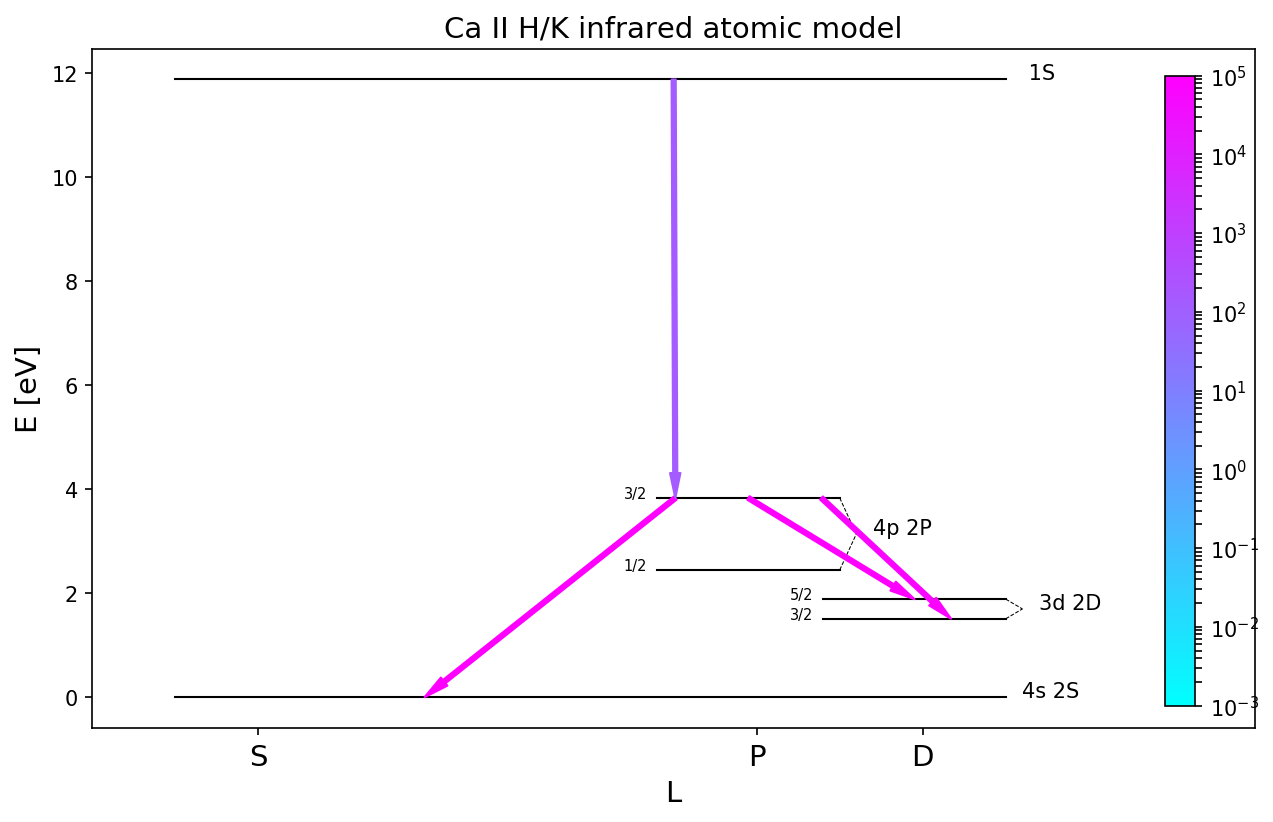

In [27]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

cmap = plt.get_cmap('cool')
norm = LogNorm(1E-3, 1E5, clip=True)


Te = 8E3
Ne = 1E12
Tr = 6E3

n_LTE , nj_by_ni_Line, nj_by_ni_Cont = Lib2.ni_nj_LTE(atom, Te, Ne)

res = Lib2.bf_R_rate(atom, Te, nj_by_ni_Cont, _Tr=Tr)
Rik, Rki_stim, Rki_spon = res
Bij_Jbar, Bji_Jbar = Lib2.B_Jbar(atom, _Tr=Tr)

rate = np.append( Bji_Jbar*nj_by_ni_Line + 
                  atom.Line.AJI*nj_by_ni_Line - 
                  Bij_Jbar,
                  Rki_stim*nj_by_ni_Cont +
                  Rki_spon*nj_by_ni_Cont - 
                  Rik )

idxI = np.append( atom.Line.idxI, atom.Cont.idxI )
idxJ = np.append( atom.Line.idxJ, atom.Cont.idxJ )

gro.plot_transition_rate(_idxI=idxI, 
                         _idxJ=idxJ, 
                         _rate=rate, 
                         _direction="j->i",
                         _cmap=cmap, _norm=norm, _abserr=1E-5,
                         _level_ctj_without_prefix=("4p","2P","3/2"))

#### collisional transition rate

we will find out the collisional transition is always under detail balance

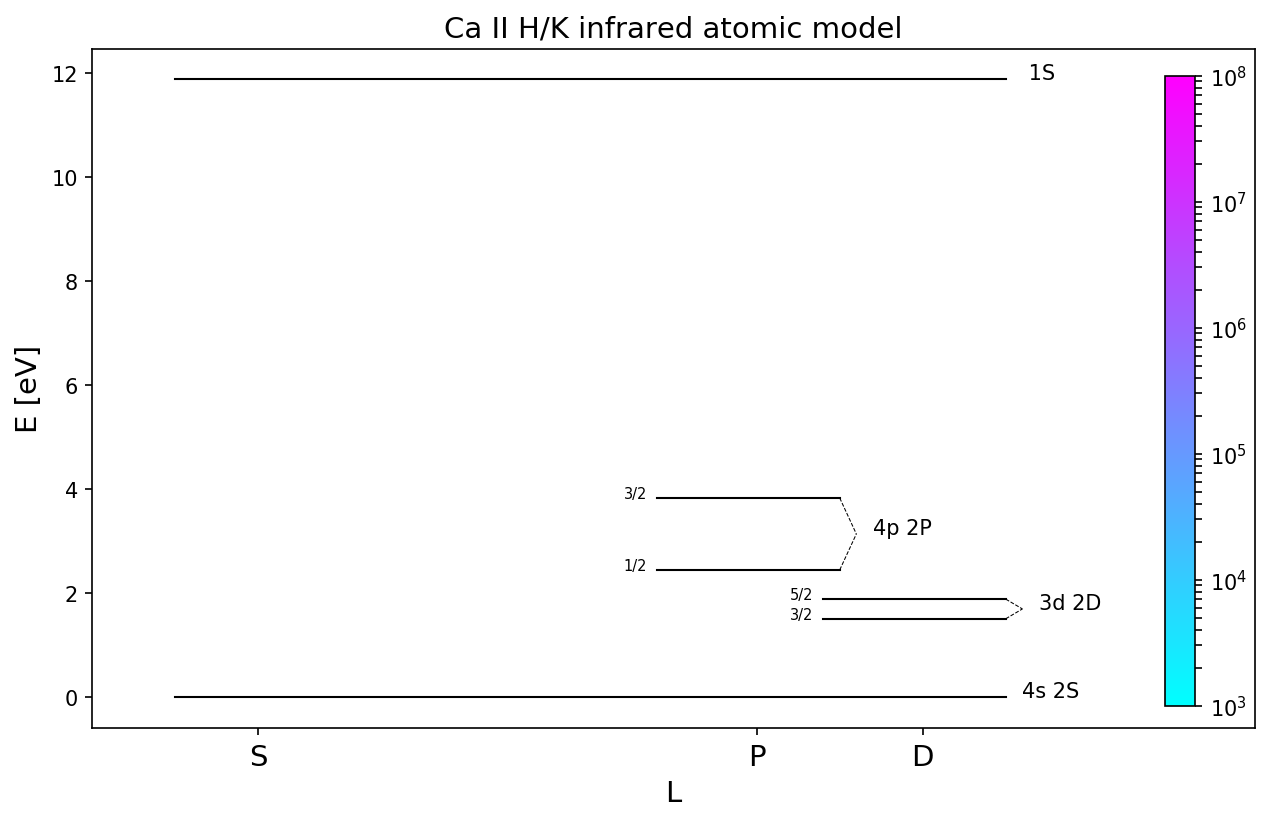

In [24]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

cmap = plt.get_cmap('cool')
norm = LogNorm(1E3, 1E8, clip=True)

Te = 1E4
Ne = 1E11

n_LTE , nj_by_ni_Line, nj_by_ni_Cont = Lib2.ni_nj_LTE(atom, Te, Ne)
nj_by_ni_all = np.append(nj_by_ni_Line,nj_by_ni_Cont)
Cij = Lib2.get_Cij(atom, Te)
Cji = Collision.Cij_to_Cji( Cij, nj_by_ni_all )

rate = (Cji*nj_by_ni_all - Cij)*Ne
idxI = np.append( atom.Line.idxI, atom.Cont.idxI )
idxJ = np.append( atom.Line.idxJ, atom.Cont.idxJ )

gro.plot_transition_rate(_idxI=idxI, 
                         _idxJ=idxJ, 
                         _rate=rate, 
                         _direction="j->i",
                         _cmap=cmap, _norm=norm, _abserr=1E-5)

---